In [1]:
import os
import sys

%matplotlib inline
import time
import pylab as pl
from IPython import display

import numpy as np
import argparse
import h5py
import math
import time
import logging
import matplotlib.pyplot as plt
import torchvision
from sklearn import metrics
import _pickle as cPickle
import shutil

from tqdm import tqdm_notebook as tqdm
import torch

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from models import CNN_two, Cnn6
from data_generator import medleyDataset, medleyDataset_logmel, medleyDataset_audio, get_mean_var

from losses import get_loss_func
from metrics import macro_f1, instrument_f1

In [2]:
def save_checkpoint(state, is_best, directory, filename='checkpoint.pth.tar'):
    if not directory == None:
        if not os.path.exists(directory):
            os.makedirs(directory)

        filename = os.path.join(directory, filename)
        torch.save(state, filename)
        if is_best:
            shutil.copyfile(filename, os.path.join(directory,'model_best.pth.tar'))

In [3]:
# scatter_type = '6_8_33075'
scatter_type = '9_8_132300'
# scatter_type = 'logmel'

train_dir = '/home/laura/MedleyDB/processed/'+scatter_type+'/train'
val_dir = '/home/laura/MedleyDB/processed/'+scatter_type+'/val'

classes_num = 16
if scatter_type == 'logmel':
    mean_logmel, var_logmel = get_mean_var(train_dir)
    time_steps = 827
    freq_bins = 64
    
    train_dataset = medleyDataset_logmel(
        train_dir, 
        time_steps, 
        freq_bins, 
        classes_num, 
        mean_logmel, 
        var_logmel
    )
    val_dataset = medleyDataset_logmel(
        val_dir, 
        time_steps, 
        freq_bins, 
        classes_num, 
        mean_logmel, 
        var_logmel
    )
    
else:
    if scatter_type == '9_8_132300':
        input_length = 259
        order1_length = 62
        order2_length = 237
    elif scatter_type == '6_8_33075':
        input_length = 517
        order1_length = 38
        order2_length = 87
    
    mean_order1, var_order1, mean_order2, var_order2 = get_mean_var(train_dir)
    train_dataset = medleyDataset(
        train_dir,
        input_length,
        order1_length,
        order2_length,
        classes_num,
        mean_order1,
        var_order1,
        mean_order2,
        var_order2
    )
    val_dataset = medleyDataset(
        val_dir,
        input_length,
        order1_length,
        order2_length,
        classes_num,
        mean_order1,
        var_order1,
        mean_order2,
        var_order2
    )
    
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=32,
    num_workers=os.cpu_count(),
    shuffle=True,
    drop_last=True
)

val_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=1,
    num_workers=os.cpu_count(),
    shuffle=True
)

print(len(train_dataset))
print(len(val_dataset))

3162
233


In [4]:
if scatter_type == "logmel":
    model = Cnn6(
        classes_num=classes_num,
        time_steps=time_steps,
        freq_bins=freq_bins,
        spec_aug=False,
    )
else:
    model = CNN_two(
        classes_num=classes_num,
        input_length=input_length,
        order1_length=order1_length,
        order2_length=order2_length,
    )

model.cuda()

loss_func = nn.BCELoss()
optimizer = optim.Adam(model.parameters())
# optimizer = optim.AdamW(model.parameters())
# optimizer = optim.ASGD(model.parameters())

In [5]:
sum(p.numel() for p in model.parameters())
print(model)

CNN_two(
  (conv_block1): ConvBlock5x5(
    (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), bias=False)
    (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_list1): ModuleList(
    (0): ConvBlock5x5(
      (conv1): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): ConvBlock5x5(
      (conv1): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (conv_block2): ConvBlock5x5(
    (conv1): Conv2d(1, 32, kernel_size=(1, 5), stride=(1, 1), padding=(2, 2), bias=False)
    (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_list2): ModuleList(
    (0): ConvBlock5x5(
      (conv1): Conv2d(32, 64, kernel_size=(1

In [6]:
losses_train = []
losses_val = []
f1_val = []
epoch = 0
threshold = 0.2
best_f1 = 0
directory_save = None

early_stop = False
plot = False
dropout = True

while not early_stop:
    running_loss = 0.0
    is_best = False
    
    # if epoch == 100:
    #     plot = True
    
    for batch_data_dict in tqdm(train_loader):
        if scatter_type == 'logmel':
            batch_input = batch_data_dict['logmel'].cuda()
            batch_target = batch_data_dict['target'].cuda()
            batch_output_dict = model(batch_input)
        else:
            batch_input1 = batch_data_dict['order1'].cuda()
            batch_input2 = batch_data_dict['order2'].cuda()
            batch_target = batch_data_dict['target'].cuda()
            batch_output_dict = model(batch_input1, batch_input2, plot, dropout)
        
        batch_target_dict = {'target': batch_target}
        
        loss = loss_func(batch_output_dict['clipwise_output'], batch_target_dict['target'])

        # Backward
        loss.backward()
        running_loss += loss.item() * train_loader.batch_size
        
        optimizer.step()
        optimizer.zero_grad()
    
    epoch_loss = running_loss / len(train_dataset)
    losses_train.append(epoch_loss)
    
    plot = False

    if epoch < 50:
        display.clear_output(wait=True)
        
    print('Epoch', epoch, ',  Train loss:', epoch_loss, end='\r')
    model.eval()

    val_loss = 0.0
    batches_target = []
    batches_pred = []
    
    for batch_data_dict in val_loader:
        if scatter_type == 'logmel':
            batch_input = batch_data_dict['logmel'].cuda()
            batch_target = batch_data_dict['target'].cuda()
            batch_output_dict = model(batch_input)
        else:
            batch_input1 = batch_data_dict['order1'].cuda()
            batch_input2 = batch_data_dict['order2'].cuda()
            batch_target = batch_data_dict['target'].cuda()
            batch_output_dict = model(batch_input1, batch_input2)
        
        batch_target_dict = {'target': batch_target}

        loss = loss_func(batch_output_dict['clipwise_output'], batch_target_dict['target'])

        val_loss += loss.item() * val_loader.batch_size

        batches_target.append(batch_target_dict['target'].detach().cpu().numpy()[0])
        batches_pred.append((batch_output_dict['clipwise_output'].detach().cpu().numpy()[0]>threshold) * 1.0)

    val_loss = val_loss / len(val_dataset)

    losses_val.append(val_loss)

    if epoch > 50 and losses_val[-1] > min(losses_val):
        f1_instr = instrument_f1(batches_target, batches_pred)
        print(f1_instr)
        early_stop = True

    f1_score = macro_f1(batches_target, batches_pred)
    f1_val.append(f1_score)
    
    if losses_val[-1] == min(losses_val):
        is_best = True
        
    save_checkpoint({
        'epoch': epoch + 1,
        'state_dict': model.state_dict(),
        'f1_score': f1_score,
        'optimizer' : optimizer.state_dict(),
    }, is_best, directory_save)
    
    model.train()

    # plt.plot(losses_train, label='Train loss')
    # plt.plot(losses_val, label='Validation loss')
    # display.clear_output(wait=True)
    # display.display(pl.gcf())
    # time.sleep(0.1)

    epoch += 1

Macro F1 0.44316539049186.13503937537273525



Macro F1 0.4386576231303319617732268537923



[0.9067357512953368, 0.9509803921568628, 0.74375, 0.7301587301587302, 0.43199999999999994, 0.7522935779816513, 0.16666666666666666, 0.48275862068965514, 0.2222222222222222, 0.30303030303030304, 0.0, 0.0, 0.42424242424242425, 0.0, 0.6341463414634146, 0.3]
Macro F1 0.4405615643692042


In [7]:
files_val = os.listdir('/home/laura/MedleyDB/processed/9_8_132300/val/input')
labels_val_dir = '/home/laura/MedleyDB/processed/9_8_132300/val/labels'

matrix_labels = []

for file in files_val:

    label = np.load(os.path.join(labels_val_dir, file), allow_pickle = True)
    matrix_labels.append(label)

num_instr = len(matrix_labels[0])
count_val = np.zeros(num_instr)

for label in matrix_labels:
    idx = np.where(label==1)
    for i in idx:
        count_val[i] = count_val[i] + 1

files_train = os.listdir('/home/laura/MedleyDB/processed/9_8_132300/train/input')
labels_train_dir = '/home/laura/MedleyDB/processed/9_8_132300/train/labels'

matrix_labels = []

for file in files_train:

    label = np.load(os.path.join(labels_train_dir, file), allow_pickle = True)
    matrix_labels.append(label)

num_instr = len(matrix_labels[0])
count_train = np.zeros(num_instr)

for label in matrix_labels:
    idx = np.where(label==1)
    for i in idx:
        count_train[i] = count_train[i] + 1

INDEX_TO_INSTRUMENT = {0: 'drums', 1: 'bass', 2: 'guitar', 3: 'voice', 4: 'piano', 5: 'synthesizer', 6: 'cello', 7: 'clarinet', 8: 'cymbals', 9: 'flute', 10: 'mallet_percussion', 11: 'mandolin', 12: 'saxophone', 13: 'trombone', 14: 'trumpet', 15: 'violin'}
F1_INSTRUMENT = {}
for i in range(len(f1_instr)):
    F1_INSTRUMENT[INDEX_TO_INSTRUMENT[i]] = [f1_instr[i], count_val[i], count_train[i]]

import pandas as pd

pd.DataFrame.from_dict(F1_INSTRUMENT, orient='index', columns=['f1 score', '# samples in val', '# samples in train'])

,f1 score,# samples in val,# samples in train
drums,0.906736,191.0,1382.0
bass,0.950980,195.0,1901.0
guitar,0.743750,130.0,1562.0
voice,0.730159,104.0,1305.0
piano,0.432000,54.0,1200.0
synthesizer,0.752294,41.0,889.0
cello,0.166667,4.0,273.0
clarinet,0.482759,16.0,143.0
cymbals,0.222222,3.0,84.0
flute,0.303030,11.0,312.0


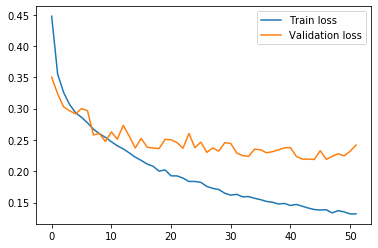

In [8]:
plt.plot(losses_train, label='Train loss')
plt.plot(losses_val, label='Validation loss')
plt.legend()
plt.show()

In [9]:
print(min(losses_train))
print(min(losses_val))
print(max(f1_val))

0.1317732268537923
0.21868565073786422
0.46637826991064424


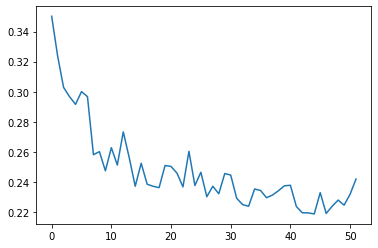

In [10]:
plt.plot(losses_val)

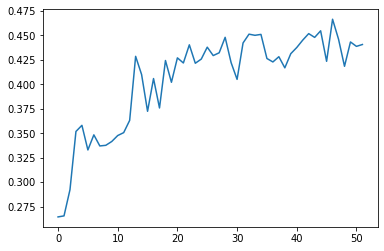

In [11]:
plt.plot(f1_val)